In [1]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import fitz  # PyMuPDF
import cv2
import pytesseract
import numpy as np
import os
import csv

def isolate_dark_shades(image_path, dark_shades_count=2):
    """
    Изолирует самые темные оттенки на изображении, заменяя остальные на белый цвет.

    :param image_path: Путь к исходному изображению.
    :param dark_shades_count: Количество темных оттенков для сохранения.
    :return: Изображение только с темными оттенками и белым фоном.
    """
    # Загрузка и подготовка изображения
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_flat = img.reshape((-1, 3))

    # Применение k-средних для нахождения основных цветов
    kmeans = KMeans(n_clusters=5, n_init=10)
    kmeans.fit(img_flat)
    dominant_colors = kmeans.cluster_centers_

    # Сортировка цветов по их яркости
    colors_brightness = np.sum(dominant_colors, axis=1)
    sorted_indices = np.argsort(colors_brightness)

    # Выбор самых темных оттенков
    dark_colors = sorted_indices[:dark_shades_count]

    # Замена пикселей, не относящихся к темным оттенкам, на белый
    for i in range(len(img_flat)):
        if kmeans.labels_[i] not in dark_colors:
            img_flat[i] = [255, 255, 255]

    return img_flat.reshape(img.shape)

    
def remove_spots(image, kernel_size=(3, 3), area_threshold=100):
    """
    Удаляет мелкие изолированные элементы (кляксы) из изображения.

    :param image: Входное изображение для обработки.
    :param kernel_size: Размер ядра для морфологических операций.
    :param area_threshold: Пороговое значение площади для удаления мелких контуров.
    :return: Обработанное изображение.
    """
    # Морфологическая эрозия и дилатация
    kernel = np.ones(kernel_size, np.uint8)
    erosion = cv2.erode(image, kernel, iterations=1)
    dilation = cv2.dilate(erosion, kernel, iterations=1)

    # Найти контуры на изображении
    contours, _ = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Создать маску для удаления мелких контуров
    mask = np.ones_like(dilation) * 255
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < area_threshold:
            cv2.drawContours(mask, [contour], -1, 0, -1)

    # Применить маску к изображению
    return cv2.bitwise_and(dilation, dilation, mask=mask)


In [7]:
# Путь к PDF файлу и путь к Tesseract
pdf_path = 'Kogan_1.pdf'
tesseract_path = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
pytesseract.pytesseract.tesseract_cmd = tesseract_path

# Папка для сохранения изображений
images_folder = 'extracted_images'
os.makedirs(images_folder, exist_ok=True)

print("Начало обработки PDF файла.")

# Открыть PDF файл
doc = fitz.open(pdf_path)

# Файл для сохранения извлеченного текста
extracted_text_path = 'extracted_text.txt'

# Открыть файл для записи извлеченного текста
with open(extracted_text_path, 'w', encoding='utf-8') as text_file:

    # Перебрать страницы и извлечь изображения
    for page_num in range(131, 132):  # Страницы с 130 по 135
        print(f"Обработка страницы {page_num + 1}...")
        page = doc.load_page(page_num)
        pix = page.get_pixmap(matrix=fitz.Matrix(5, 5))
        img_data = pix.tobytes("png")
        img = cv2.imdecode(np.frombuffer(img_data, np.uint8), 1)

        # Сохранение оригинального изображения
        original_img_path = os.path.join(images_folder, f'page_{page_num + 1}_original.png')
        cv2.imwrite(original_img_path, img)       

        # Обработка сохраненного изображения
        img = isolate_dark_shades(original_img_path, dark_shades_count=2)
        if img is not None:
            cv2.imwrite(original_img_path, img)       

        # Адаптивная пороговая обработка и удаление "клякс"
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        processed_img = remove_spots(thresh, kernel_size=(5, 5), area_threshold=100)        

        # Сохранить обработанное изображение и анализировать цветовую палитру
        processed_img_path = os.path.join(images_folder, f'page_{page_num + 1}_processed.png')
        cv2.imwrite(processed_img_path, thresh)        

        # OCR и сохранение текста
        custom_config = r'--oem 3 --psm 6'
        text = pytesseract.image_to_string(thresh, config=custom_config, lang='rus+eng')
        text_file.write(f'--- Страница {page_num + 1} ---\n{text}\n')

# Закрыть PDF файл
doc.close()

print("Обработка PDF файла завершена.")


Начало обработки PDF файла.
Обработка страницы 132...
Обработка PDF файла завершена.


In [3]:
def detect_column_names_area(img_path, debug=False):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=20)
    img_height, img_width = img.shape[:2]
    horizontal_lines = []

    # Обнаружение горизонтальных линий
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < 10 and (x2 - x1) > img_width / 10:  # Угол почти горизонтальный и ширина линии достаточная
            horizontal_lines.append((x1, y1, x2, y2))

    # Объединение линий, находящихся на одной высоте
    combined_lines = []
    height_tolerance = img_height / 100

    for line in horizontal_lines:
        x1, y1, x2, y2 = line
        combined = False

        for combined_line in combined_lines:
            cx1, cy1, cx2, cy2 = combined_line
            if abs(y1 - cy1) <= height_tolerance:
                new_x1 = min(x1, cx1)
                new_x2 = max(x2, cx2)
                combined_lines.remove(combined_line)
                combined_lines.append((new_x1, cy1, new_x2, cy2))
                combined = True
                break
        
        if not combined:
            combined_lines.append(line)

    # Отображение объединенных линий
    if debug:
        for line in combined_lines:
            x1, y1, x2, y2 = line
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Красный цвет для объединенных линий

    # Сохранение отладочного изображения
    if debug:
        cv2.imwrite('debug_column_names_area.png', img)

    return combined_lines

# Пример использования функции с включенным режимом отладки
column_names_area = detect_column_names_area('extracted_images\page_134_processed.png', debug=True)


In [7]:
def find_horizontal_lines(img, min_width):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=min_width, maxLineGap=20)
    horizontal_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < 10:  # Угол почти горизонтальный
            horizontal_lines.append((x1, y1, x2, y2))

    return horizontal_lines

def combine_lines(lines, height_tolerance):
    combined_lines = []

    for line in lines:
        x1, y1, x2, y2 = line
        combined = False

        for combined_line in combined_lines:
            cx1, cy1, cx2, cy2 = combined_line
            if abs(y1 - cy1) <= height_tolerance:
                new_x1 = min(x1, cx1)
                new_x2 = max(x2, cx2)
                combined_lines.remove(combined_line)
                combined_lines.append((new_x1, cy1, new_x2, cy2))
                combined = True
                break
        
        if not combined:
            combined_lines.append(line)

    return combined_lines

def filter_lines_by_width(lines, min_width):
    return [line for line in lines if line[2] - line[0] >= min_width]

def detect_column_names_area(img_path, debug=False):
    img = cv2.imread(img_path)
    img_height, img_width = img.shape[:2]

    # Обнаружение горизонтальных линий
    horizontal_lines = find_horizontal_lines(img, img_width / 10)

    # Объединение горизонтальных линий
    combined_lines = combine_lines(horizontal_lines, img_height / 100)

    # Фильтрация линий по ширине
    filtered_lines = filter_lines_by_width(combined_lines, img_width / 3)

    # Отображение отфильтрованных линий
    if debug:
        for line in filtered_lines:
            x1, y1, x2, y2 = line
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Красный цвет для отфильтрованных линий

    # Сохранение отладочного изображения
    if debug:
        cv2.imwrite('debug_column_names_area.png', img)

    return filtered_lines

# Пример использования функции с включенным режимом отладки
column_names_area = detect_column_names_area('extracted_images\page_131_processed.png', debug=True)


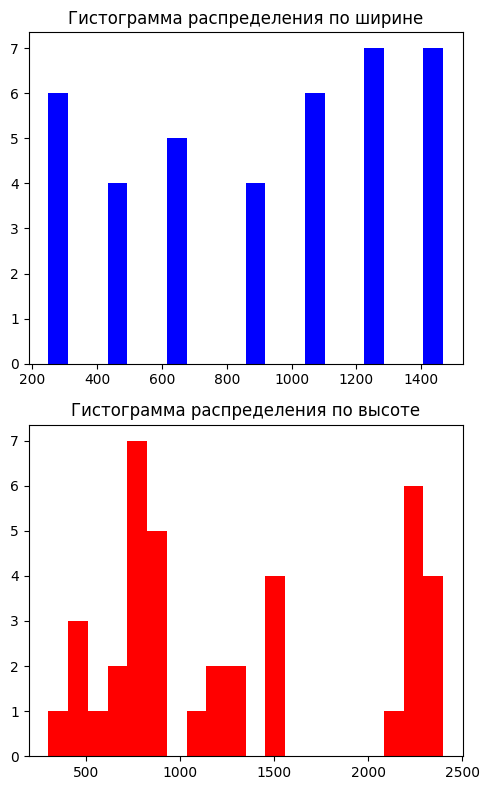

In [3]:
def line_intersects_rect(line, rect):
    x1, y1, x2, y2 = line
    rx, ry, rw, rh = rect
    # Проверка пересечения линии с каждой стороной прямоугольника
    return (x1 < rx + rw and x2 > rx and y1 < ry + rh and y2 > ry) or \
           (x1 > rx and x2 < rx + rw and y1 > ry and y2 < ry + rh)

def filter_lines_crossing_text(img, lines, threshold=1):
    d = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, config='--oem 3 --psm 6', lang='rus+eng')
    filtered_lines = []

    for line in lines:
        intersect_count = 0
        line_coords = (line[0], line[1], line[2], line[3])

        for i in range(len(d['text'])):
            if int(d['conf'][i]) > 60:
                rect_coords = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
                if line_intersects_rect(line_coords, rect_coords):
                    intersect_count += 1

        if intersect_count <= threshold:
            filtered_lines.append(line)

    return filtered_lines

def find_vertical_lines(img, min_height):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=min_height, maxLineGap=20)
    vertical_lines = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(x2 - x1) < 10:  # Угол почти вертикальный
            vertical_lines.append((x1, y1, x2, y2))

    return vertical_lines

def combine_close_vertical_lines(lines, width_threshold):
    def can_combine(line1, line2):
        # Проверяет, могут ли две линии быть объединены
        _, y1_1, _, y2_1 = line1
        _, y1_2, _, y2_2 = line2
        return not (y2_1 < y1_2 or y2_2 < y1_1)

    while True:
        combined_lines = []
        lines = sorted(lines, key=lambda x: x[0])  # Сортируем линии по X координате
        used_lines = set()

        for i, current_line in enumerate(lines):
            if i in used_lines:
                continue

            x1, y1, x2, y2 = current_line
            to_combine = [current_line]
            used_lines.add(i)

            for j, other_line in enumerate(lines):
                if j in used_lines:
                    continue

                ox1, oy1, ox2, oy2 = other_line
                if abs(ox1 - x1) < width_threshold and can_combine(current_line, other_line):
                    to_combine.append(other_line)
                    used_lines.add(j)

            # Вычисляем среднюю X координату
            avg_x = int(sum([l[0] for l in to_combine]) / len(to_combine))
            min_y = min([l[1] for l in to_combine])
            max_y = max([l[3] for l in to_combine])
            combined_lines.append((avg_x, min_y, avg_x, max_y))

        if len(combined_lines) == len(lines):
            break  # Прекращаем, если не произошло изменений
        lines = combined_lines

    return combined_lines

def detect_column_values_area(img_path, debug=False):
    img = cv2.imread(img_path)
    img_height, img_width = img.shape[:2]

    # Обнаружение вертикальных линий
    vertical_lines = find_vertical_lines(img, img_height / 10)

    # Объединение близких вертикальных линий
    width_threshold = img_width / 10
    combined_lines = combine_close_vertical_lines(vertical_lines, width_threshold)

    # Фильтрация линий, пересекающих текст
    filtered_lines = filter_lines_crossing_text(img, combined_lines)

    # Отображение отфильтрованных линий
    if debug:
        for line in filtered_lines:
            x1, y1, x2, y2 = line
            cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Синий цвет для вертикальных линий

    # Сохранение отладочного изображения
    if debug:
        cv2.imwrite('debug_column_values_area.png', img)

    # Отображение гистограмм и сохранение данных в CSV
    if debug:
        centers_x = [(line[0] + line[2]) / 2 for line in filtered_lines]
        centers_y = [(line[1] + line[3]) / 2 for line in filtered_lines]

        fig, axs = plt.subplots(2, 1, figsize=(5, 8))

        axs[0].hist(centers_x, bins=20, color='blue')
        axs[0].set_title('Гистограмма распределения по ширине')

        axs[1].hist(centers_y, bins=20, color='red')
        axs[1].set_title('Гистограмма распределения по высоте')

        plt.tight_layout()
        plt.savefig('debug_histograms.png')

        # Сохранение данных гистограмм в CSV файл
        with open('histogram_data.csv', 'w', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(['Center_X', 'Center_Y'])
            csvwriter.writerows(zip(centers_x, centers_y))


    return filtered_lines    

# Пример использования функции с включенным режимом отладки
column_values_area = detect_column_values_area('extracted_images\page_132_processed.png', debug=True)



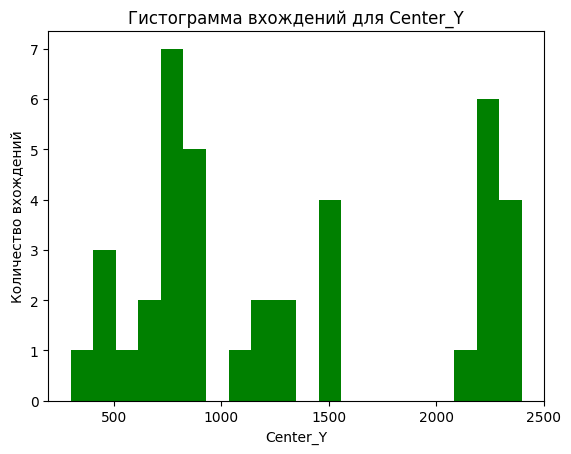

In [8]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv('histogram_data.csv')

# Гистограмма для 'Center_Y'
plt.hist(df['Center_Y'], bins=20, color='green')
plt.title('Гистограмма вхождений для Center_Y')
plt.xlabel('Center_Y')
plt.ylabel('Количество вхождений')
plt.show()



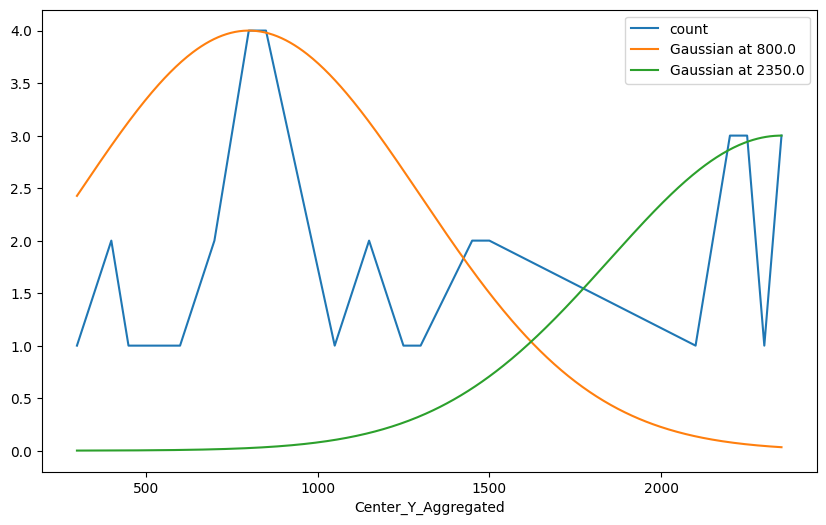

In [17]:
# Сначала создаем новый столбец для агрегированных значений
df['Center_Y_Aggregated'] = (df['Center_Y'] // 50) * 50

# Теперь считаем количество вхождений для каждой агрегированной категории
aggregated_counts = df['Center_Y_Aggregated'].value_counts().sort_index()
import numpy as np
import matplotlib.pyplot as plt

# Поиск двух самых высоких точек, удовлетворяющих условию минимального расстояния
top_points = aggregated_counts.nlargest(len(aggregated_counts))
min_distance = 500

# Инициализация переменных для двух наивысших точек, удовлетворяющих условию
top_point_1 = None
top_point_2 = None

for idx, value in top_points.items():
    if top_point_1 is None:
        top_point_1 = (idx, value)
    elif abs(idx - top_point_1[0]) >= min_distance:
        top_point_2 = (idx, value)
        break

# Проверка, найдены ли обе точки
if top_point_2 is None:
    raise ValueError("Не удалось найти две точки, удовлетворяющие условию минимального расстояния.")

# Функция для гауссианы
def gaussian(x, mu, sigma, height):
    return height * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

# Создаем массив значений x для графика
x_values = np.linspace(aggregated_counts.index.min(), aggregated_counts.index.max(), 500)

# Инициализация графика
plt.figure(figsize=(10, 6))

# Рисуем исходные данные
aggregated_counts.plot()

# Рисуем гауссианы для двух наибольших точек, удовлетворяющих условию
for idx, value in [top_point_1, top_point_2]:
    y_values = gaussian(x_values, idx, 500, value)
    plt.plot(x_values, y_values, label=f'Gaussian at {idx}')

plt.legend()
plt.show()


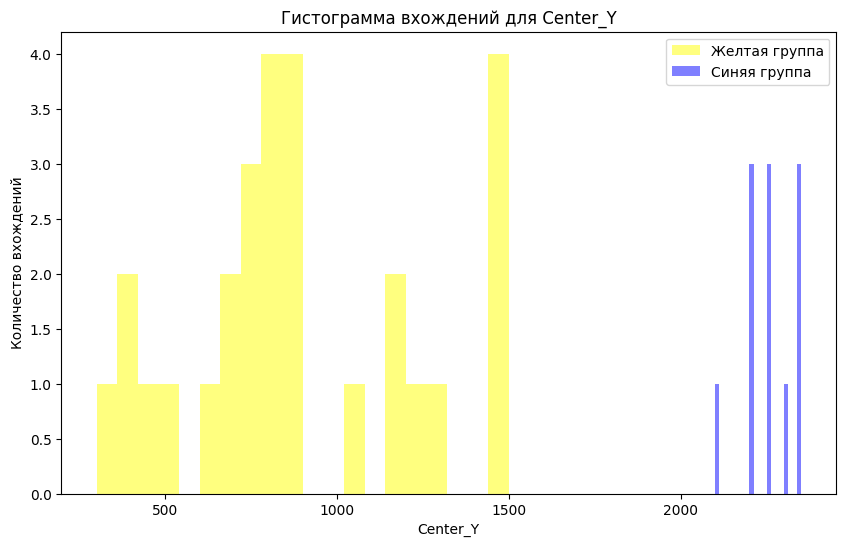

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('histogram_data.csv')

# Создание нового столбца для агрегированных значений
df['Center_Y_Aggregated'] = (df['Center_Y'] // 50) * 50

# Подсчет количества вхождений для каждой агрегированной категории
aggregated_counts = df['Center_Y_Aggregated'].value_counts().sort_index()

# Поиск двух самых высоких точек
top_points = aggregated_counts.nlargest(len(aggregated_counts))
min_distance = 500
top_point_1 = None
top_point_2 = None

for idx, value in top_points.items():
    if top_point_1 is None:
        top_point_1 = (idx, value)
    elif abs(idx - top_point_1[0]) >= min_distance:
        top_point_2 = (idx, value)
        break

if top_point_2 is None:
    raise ValueError("Не удалось найти две точки, удовлетворяющие условию минимального расстояния.")

# Функция для гауссианы
def gaussian(x, mu, sigma, height):
    return height * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

# Разделение значений на две группы
yellow_group = []
blue_group = []

for idx in aggregated_counts.index:
    gauss_1_value = gaussian(idx, top_point_1[0], 500, top_point_1[1])
    gauss_2_value = gaussian(idx, top_point_2[0], 500, top_point_2[1])

    if gauss_1_value > gauss_2_value:
        yellow_group.append(idx)
    else:
        blue_group.append(idx)

# Рисование гистограммы с разделением на группы
plt.figure(figsize=(10, 6))
plt.hist(df[df['Center_Y_Aggregated'].isin(yellow_group)]['Center_Y_Aggregated'], bins=20, color='yellow', alpha=0.5, label='Желтая группа')
plt.hist(df[df['Center_Y_Aggregated'].isin(blue_group)]['Center_Y_Aggregated'], bins=20, color='blue', alpha=0.5, label='Синяя группа')

plt.title('Гистограмма вхождений для Center_Y')
plt.xlabel('Center_Y')
plt.ylabel('Количество вхождений')
plt.legend()
plt.show()


In [2]:
import re

def count_matching_lines(filename, pattern):
    # Счётчик строк, соответствующих шаблону
    count = 0

    # Открываем файл и читаем его построчно
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # Проверяем, соответствует ли строка шаблону
            if re.search(pattern, line):
                count += 1

    return count

# Регулярное выражение, заданное в запросе
general_regex = r"([NnеНЕмт№]\s?\d*\.?\d*\s?.*?\[.*?\])"
count_matching_lines("extracted_text.txt", general_regex)

2